In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans, KShape, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import import_ipynb
import sklearn
import tslearn
from concurrent.futures import ProcessPoolExecutor
import os
import pickle
import time
import re
from sklearn.metrics import silhouette_samples
from tslearn.metrics import cdist_soft_dtw_normalized, cdist_dtw
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering

/home/kuba/.local/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
import Prepare_time_series as pts

importing Jupyter notebook from Prepare time series.ipynb


In [3]:
np.set_printoptions(suppress=True, precision=5)

In [4]:
KatalogPickli="Pickle"
outDir="../src/OutDir"

In [11]:
def standaryzacjaSzeregow(szeregi):
    for i in range(szeregi.shape[0]):
        szeregi[i,:]-=szeregi[i,:].mean()
        szeregi[i,:]/=szeregi[i,:].std()

In [5]:
with open(os.path.join(KatalogPickli, "Ecola-szeregi256"), "rb") as plik:
    szeregi=pickle.load(plik)
#with open(os.path.join(outDir, "odl-1628280473.9647186-gamma-7.0.pickle"), "rb") as plik:
#    odl=pickle.load(plik)
#with open(os.path.join(outDir, "odl-Ecola-wygladzone-ustandaryzowane.pickle1627817822.0182662dtw.pickle"), "rb") as plik:
#    odlDtw=pickle.load(plik)

In [13]:
szeregi=np.array(szeregi)

In [14]:
szeregi.shape

(4081, 256)

In [15]:
np.mean(szeregi[0,:])

0.018416060728185316

In [16]:
standaryzacjaSzeregow(szeregi)

In [17]:
np.mean(szeregi[0,:])

-1.1102230246251565e-16

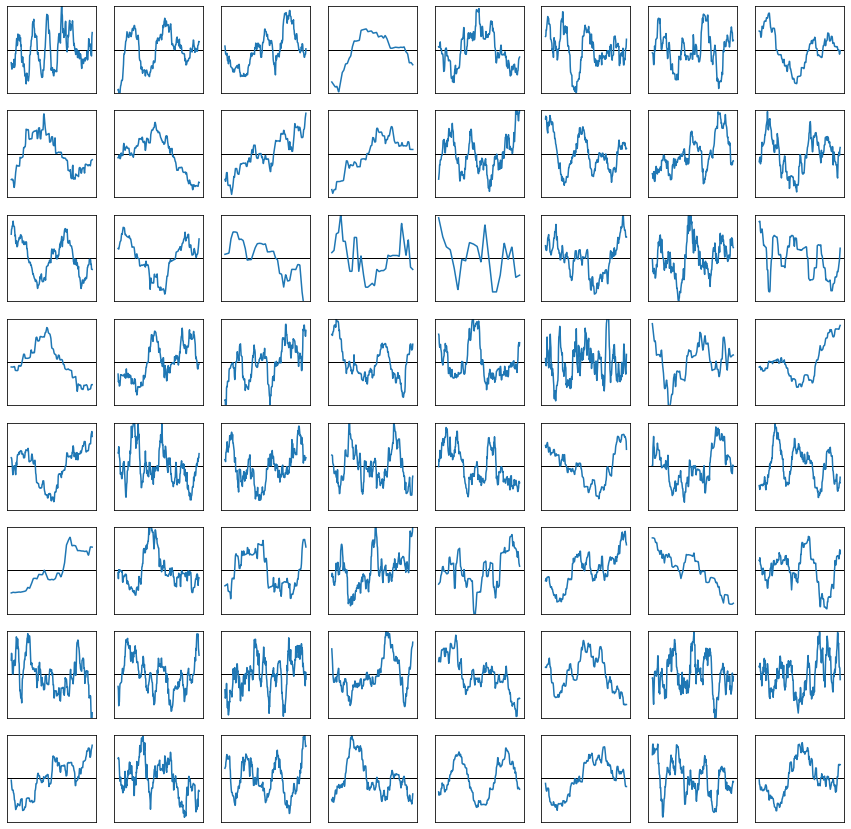

In [23]:
plt.gcf().set_size_inches(15,15)
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.ylim(-2.5,2.5)
    plt.tick_params(axis='both',which='both', bottom=False,top=False, left=False, labelleft=False, labelbottom=False)
    plt.axhline(c="black", lw=1)
    plt.plot(szeregi[i,:])

In [24]:
with open(os.path.join(KatalogPickli, "Ecola-szeregi256-std-bezWygl"), "wb") as plik:
    pickle.dump(szeregi,plik)

# Softdtw

### Wykres silhouette

In [5]:
reExpr=re.compile(r".*7\.0\.pickle")
reExprOdl=re.compile(r".*odl.*")

In [6]:
listaPasujacych=[]
for plik in os.listdir("../src/OutDir"):
    if reExpr.match(plik) is not None and reExprOdl.match(plik) is None:
        listaPasujacych.append(plik)

In [7]:
listaPasujacych

['1628262068.411241-n_cluster-2-gamma-7.0.pickle',
 '1628265735.8611352-n_cluster-7-gamma-7.0.pickle',
 '1628264610.2424963-n_cluster-5-gamma-7.0.pickle',
 '1628263995.9116056-n_cluster-4-gamma-7.0.pickle',
 '1628263287.782947-n_cluster-3-gamma-7.0.pickle',
 '1628265393.8338711-n_cluster-6-gamma-7.0.pickle']

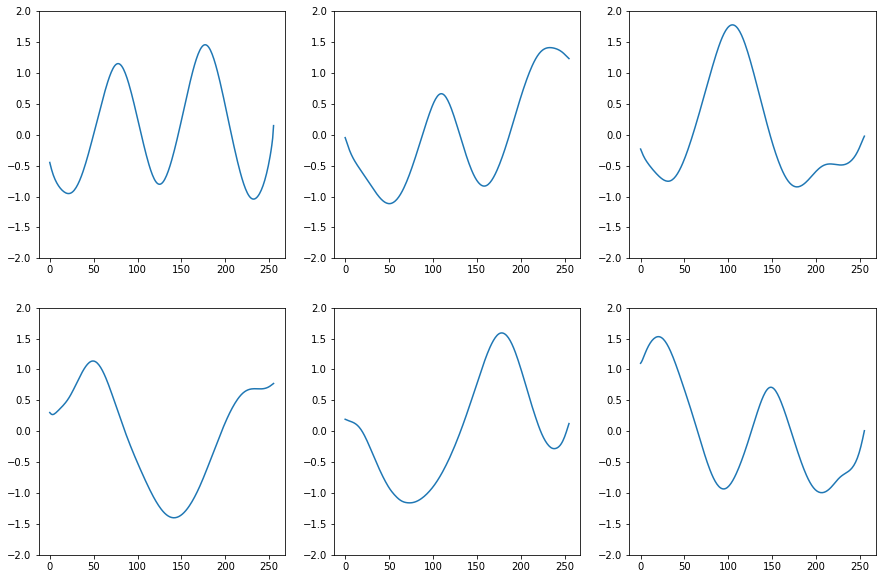

In [9]:
with open(os.path.join("../src/OutDir/",'1628265393.8338711-n_cluster-6-gamma-7.0.pickle'), "rb") as file:
        model=pickle.load(file)
plt.gcf().set_size_inches(15,10)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.ylim(-2, 2)
    plt.plot(model.cluster_centers_[i].ravel())

In [10]:
etykiety=model.predict(szeregi)

/home/kuba/.local/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 4081 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [11]:
np.unique(etykiety, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([716, 694, 703, 604, 637, 727]))

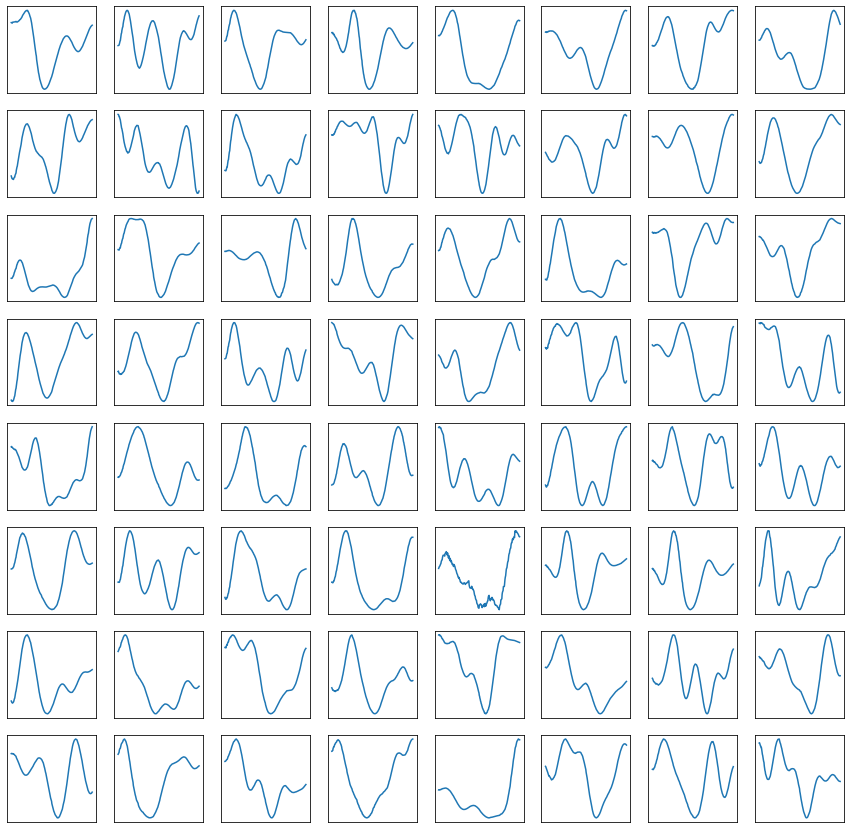

In [12]:
k=3
plt.gcf().set_size_inches(15,15)
szeregiWKtejGrupie=szeregi[etykiety==k,:]
for i in range(64):
    plt.subplot(8,8,i+1)
    #plt.ylim(0.005, 0.045)
    plt.tick_params(axis='both',which='both', bottom=False,top=False, left=False, labelleft=False, labelbottom=False)
    plt.plot(szeregiWKtejGrupie[i])

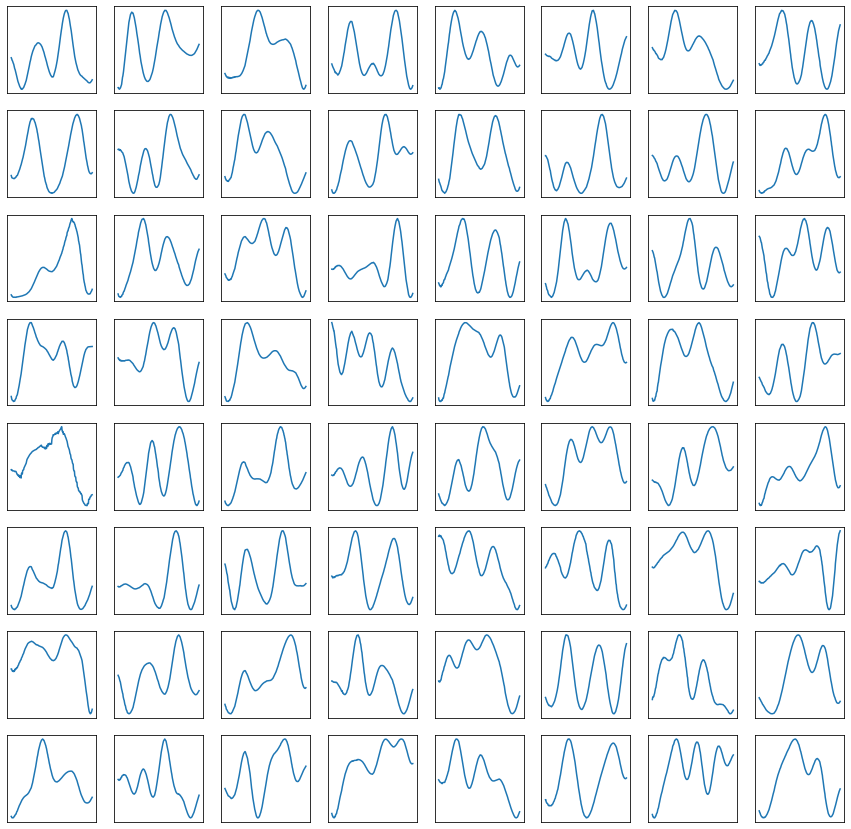

In [13]:
k=0
plt.gcf().set_size_inches(15,15)
szeregiWKtejGrupie=szeregi[etykiety==k,:]
for i in range(64):
    plt.subplot(8,8,i+1)
    #plt.ylim(0.005, 0.045)
    plt.tick_params(axis='both',which='both', bottom=False,top=False, left=False, labelleft=False, labelbottom=False)
    plt.plot(szeregiWKtejGrupie[i])

# Analiza

In [14]:
model.n_clusters

6

In [15]:
with open(os.path.join(outDir,"katalogFunkcjonalnosciGenow.pickle"), "rb") as plik:
    slownikFunGenow=pickle.load(plik)
with open(os.path.join(KatalogPickli,"Ecola-wygladzone-ustandaryzowane.pickle-paths"), "rb") as plik:
    szeregiNazwy=pickle.load(plik)

In [26]:
_,_, dlSeq=pts.przygotujSzeregiCzasowe(50, 256)

In [48]:
def zrobStatystykeWystapienGrupFunkcjonalnych(model, etykiety, szeregi, szeregiNazwy,
                                              dlSeq=None, minDl=None, maxDl=None):
    wystapieniaLiter={}
    bledneNazwy=[]
    for k in range(model.n_clusters):
        if dlSeq is not None:
            print("dlSeq is not None")
            maskaWyboru=np.logical_and(np.logical_and(etykiety==k,dlSeq>=minDl), dlSeq<=maxDl)
        else:
            maskaWyboru=(etykiety==k)
        wybraneNazwy=np.array(szeregiNazwy)[maskaWyboru]
        for nazwa in wybraneNazwy:
            if nazwa not in slownikFunGenow:
                bledneNazwy.append(nazwa)
                litera="XX"
            else:
                litera=slownikFunGenow[nazwa]
            if litera not in wystapieniaLiter:
                wystapieniaLiter[litera]=dict([(i,0) for i in range(model.n_clusters)])
            wystapieniaLiter[litera][k]+=1
    print(f"Liczba błędnych nazw: {len(bledneNazwy)}")
    return wystapieniaLiter, bledneNazwy

In [17]:
def rysujWykresySlupkoweDlaGrupFunkcjonalnych(wystapieniaLiter, etykiety, normalizacja=False):
    plt.gcf().set_size_inches(15,10)
    i=0
    L=list(wystapieniaLiter.items())
    L.sort()
    wystapieniaLiter=dict(L)
    czestosc=np.unique(etykiety, return_counts=True)[1]
    for litera in wystapieniaLiter:
        i+=1
        elementy=np.array(list(wystapieniaLiter[litera].items()))
        plt.subplot(5,5,i)
        if normalizacja:
            plt.bar(elementy[:,0], elementy[:,1]/czestosc)
        else:
            plt.bar(elementy[:,0], elementy[:,1])
        plt.title(litera)
        plt.tick_params(axis='both',which='both', bottom=False,top=False, labelbottom=False)
    plt.show()

In [18]:
wystapieniaLiter, bledneNazwy=zrobStatystykeWystapienGrupFunkcjonalnych(model, etykiety, szeregi, szeregiNazwy)

Liczba błędnych nazw: 387


In [19]:
bledneNazwy[0]

'lcl|NC_000913.3_cds_NP_414615.4_74 [gene=leuB] [locus_tag=b0073] [db_xref=UniProtKB/Swiss-Prot:P30125] [protein=3-isopropylmalate dehydrogenase] [protein_id=NP_414615.4] [location=complement(80867..81958)] [gbkey=CDS]'

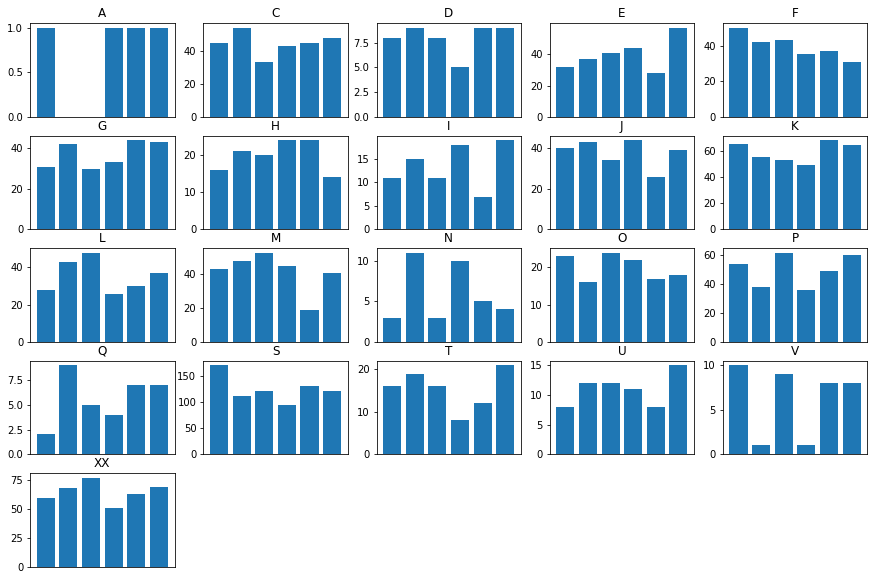

In [20]:
rysujWykresySlupkoweDlaGrupFunkcjonalnych(wystapieniaLiter, etykiety)

- E i U mają podobną charakterystykę
- L i XX
- M I E U mają podobną charakterystykę trzech ostatnich grup
- S jest jedyną grupą z dominacją pierwszego klastra, ma pewne podobieństwa z F (ale mogą być nieistotne statystycznie)
- z drugiej strony pierwszego klastra jest bardzo mało w Q i N
- P i T mają podobną charakterystykę 3 ostatnich klastrów


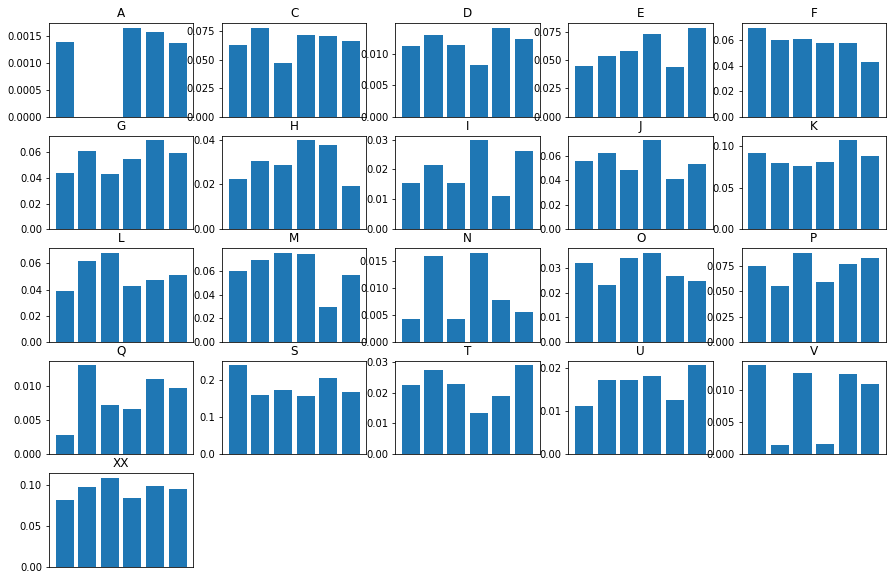

In [21]:
rysujWykresySlupkoweDlaGrupFunkcjonalnych(wystapieniaLiter, etykiety, True)

### ToDo: Analizy pod względem orginalnej długości

Q - secondary metabolities - duże ppb mutacji na końcu (tendencja wzrostowa)

V - defence mechanism - duże ppb zmutowania na początku, lub początek i koniec takie same, wysokie ppb zmutowania w środku

N - cell motility (mobility?) - ma odwrotną charakterystkę w porównaniu do V

I - lipid transport - małe ppb w środu lub tendencja spadkowa

--------------------

J - translation rybosomal - minimalizuje ppb w środku

L - replication recombination - zwiększa ppb w środku


In [14]:
256/3

85.33333333333333

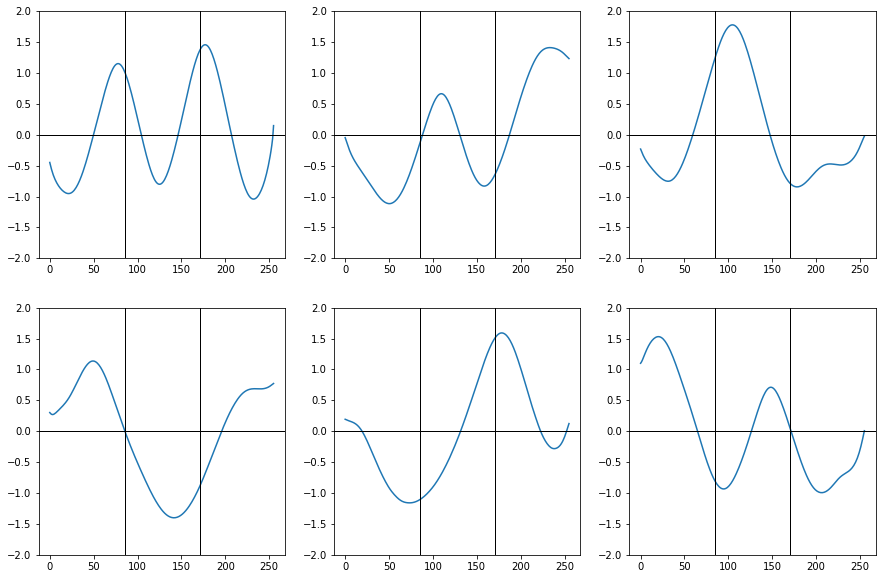

In [16]:
with open(os.path.join("../src/OutDir/",'1628265393.8338711-n_cluster-6-gamma-7.0.pickle'), "rb") as file:
        model=pickle.load(file)
plt.gcf().set_size_inches(15,10)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.ylim(-2, 2)
    plt.plot(model.cluster_centers_[i].ravel())
    plt.axhline(0,color="k", lw=1)
    plt.axvline(85.33, c='k',lw=1)
    plt.axvline(85.33*2, c='k',lw=1)

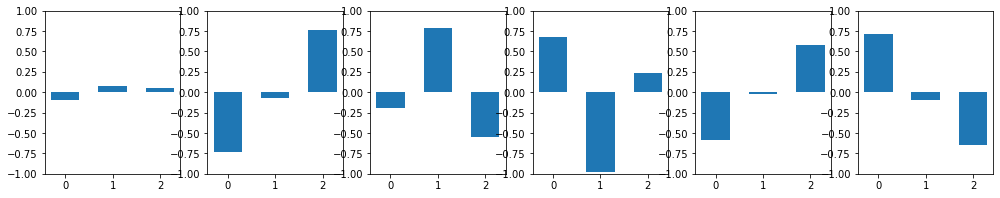

In [22]:
plt.gcf().set_size_inches(17,3)
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.ylim(-1, 1)
    plt.bar([0,1,2],
            [model.cluster_centers_[i].ravel()[:85].mean(),model.cluster_centers_[i].ravel()[85:2*85].mean(),model.cluster_centers_[i].ravel()[2*85:].mean()],
            width=0.6)

### Analizy długości

In [52]:
wystapieniaLiter, bledneNazwy=zrobStatystykeWystapienGrupFunkcjonalnych(model, etykiety, szeregi, szeregiNazwy,
                                                                        dlSeq=np.array(dlSeq), minDl=0, maxDl=250)

dlSeq is not None
dlSeq is not None
dlSeq is not None
dlSeq is not None
dlSeq is not None
dlSeq is not None
Liczba błędnych nazw: 183


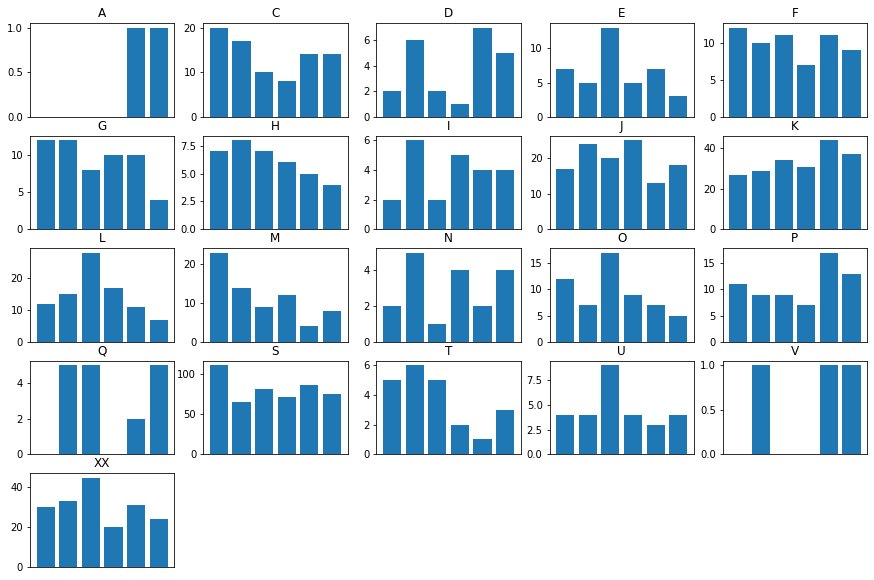

In [53]:
rysujWykresySlupkoweDlaGrupFunkcjonalnych(wystapieniaLiter, etykiety)

In [54]:
wystapieniaLiter, bledneNazwy=zrobStatystykeWystapienGrupFunkcjonalnych(model, etykiety, szeregi, szeregiNazwy,
                                                                        dlSeq=np.array(dlSeq), minDl=300, maxDl=100000)

dlSeq is not None
dlSeq is not None
dlSeq is not None
dlSeq is not None
dlSeq is not None
dlSeq is not None
Liczba błędnych nazw: 166


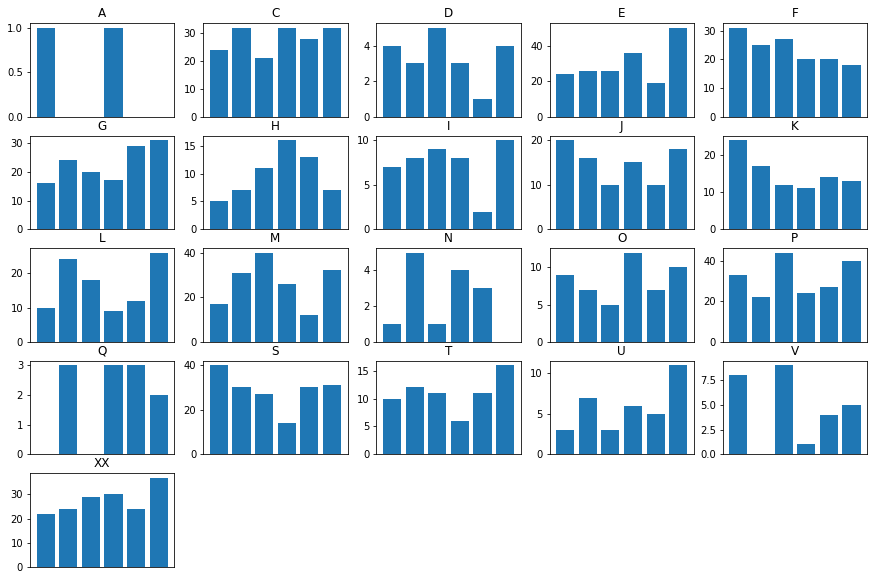

In [55]:
rysujWykresySlupkoweDlaGrupFunkcjonalnych(wystapieniaLiter, etykiety)